In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'DeepMicroC-master'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME
!pip install bioframe
!pip install cooler

Mounted at /content/drive
/content/drive/My Drive/DeepMicroC-master
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 3.4 MB/s 
     |████████████████████████████████| 102 kB 34.5 MB/s 
     |████████████████████████████████| 475 kB 45.0 MB/s 
     |████████████████████████████████| 130 kB 35.8 MB/s 
     |████████████████████████████████| 65 kB 3.4 MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.10.1-cp37-cp37m-linux_x86_64.whl size=1238271 sha256=80f1b8892d39159a08e00b84fc306c5845b03a06378bce9811a68bb8c07c185d
  Stored in directory: /root/.cache/pip/wheels/db/f0/a6/8d56aaec49585b245b0694bf8972e50a3b2a83331657ea7e95
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=9c245df31d2fb56f9c375561133

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import cooler
import pandas as pd
import bioframe as bf
from tqdm.autonotebook import tqdm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [3]:
current_dir = '/content/drive/MyDrive/DeepMicroC-master'
regions_path = os.path.join(current_dir, 'data/regions_10kb.tsv')
cooler_path = '/content/drive/MyDrive/data'

In [4]:
resolution = 5000
regionsize = 1000000

In [5]:
hic_dict = {}
for path in glob(cooler_path+'/**/*.mcool', recursive=True):
    hic_dict[path.split('/')[-3]+'_'+path.split('/')[-2].lower() ]=path

hic_dict

{}

In [6]:
regions_array = np.squeeze(pd.read_csv('data/regions.tsv', header=None).values)
regions_df = bf.from_any(list(regions_array))

In [7]:
def get_all_regions(regions_df, regionsize, step=10000):
    mask = (regions_df.end - regions_df.start) > regionsize
    all_regions = []
    for i, row in regions_df[mask].iterrows():
        if (row.end - row.start)-regionsize < 0:
          continue

        for k in range(0, (row.end - row.start)-regionsize+1, step):
            region = bf.to_ucsc_string((row.chrom, row.start+k, row.start+k+regionsize))
            all_regions.append(region)
    
    return bf.from_any(all_regions)

In [8]:
all_regions_df = get_all_regions(regions_df, regionsize, step=200000)

In [9]:
all_regions_df

,chrom,start,end
0,chr1,781250,1781250
1,chr1,981250,1981250
2,chr1,1181250,2181250
3,chr1,1381250,2381250
4,chr1,2781250,3781250
...,...,...,...
11742,chr22,48800000,49800000
11743,chr22,49000000,50000000
11744,chr22,49200000,50200000
11745,chr22,49400000,50400000


In [11]:
all_regions_df.to_csv('data/regions_1Mb.tsv', index=False, sep='\t')

In [ ]:
cell_type = 'H1'
hic = cooler.Cooler(hic_dict[cell_type+'_hic']+'::resolutions/'+str(resolution))
microc = cooler.Cooler(hic_dict[cell_type+'_microc']+'::resolutions/'+str(resolution))

In [ ]:
from utils.matutils import process_mat

In [ ]:
train_mat = np.zeros((len(all_regions_df), 1, 200, 200), dtype='float32')
target_mat = np.zeros((len(all_regions_df), 1, 200, 200), dtype='float32')

In [ ]:
for i, row in tqdm(all_regions_df.iterrows()):
  chrom = all_regions_df.iloc[i].chrom
  start = all_regions_df.iloc[i].start
  mat1 = hic.matrix(balance=True).fetch((chrom, start, start+regionsize))
  mat2 = microc.matrix(balance=True).fetch((chrom, start, start+regionsize))

  train_mat[i][0] = process_mat(mat1[:200, :200])
  target_mat[i][0] = process_mat(mat2[:200, :200])

0it [00:00, ?it/s]

In [ ]:
train_mat.shape

(11747, 1, 200, 200)

In [ ]:
np.savez_compressed('data/train_data', train=train_mat, target=target_mat)

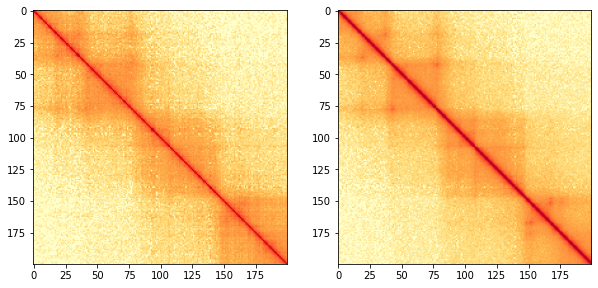

In [ ]:
k = 2014
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(train_mat[k, 0], cmap='YlOrRd')
plt.subplot(1,2,2)
plt.imshow(target_mat[k, 0], cmap='YlOrRd')